In [ ]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
print(torch.tensor([0]))

tensor([0])


In [ ]:
# from skorch import NeuralNetClassifier
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# import torch.nn as nn
# import torch.optim as optim


We always check that we are running on a GPU

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We download the dataset when the notebook starts, because it's no longer in the local session

In [ ]:
if not os.path.exists('./hotdog_nothotdog'):
  import gdown
  url = 'https://drive.google.com/uc?id=1hwyBl4Fa0IHihun29ahszf1M2cxn9TFk'
  gdown.download(url, './hotdog_nothotdog.zip', quiet=False)
  !unzip ./hotdog_nothotdog.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1hwyBl4Fa0IHihun29ahszf1M2cxn9TFk
To: /content/hotdog_nothotdog.zip
271MB [00:02, 96.6MB/s]


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use

In [ ]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [ ]:
# size = 128
# train_transform = transforms.Compose([transforms.Resize((size, size)), 
#                                     transforms.ToTensor()])
# test_transform = transforms.Compose([transforms.Resize((size, size)), 
#                                     transforms.ToTensor()])

# batch_size = 64
# trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
# train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
# testset = Hotdog_NotHotdog(train=False, transform=test_transform)
# test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [ ]:
size = 128
transformOpt = transforms.Compose([
      transforms.RandomAffine(
          degrees=10,
          translate=(0.05,0.05),
          scale=(0.9,1.1),
          shear=10
      ),
      transforms.Resize((size, size)), 
      transforms.ToTensor()
  ])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=transformOpt)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=transformOpt)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [ ]:
type(trainset)

__main__.Hotdog_NotHotdog

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
type(trainset)
type(train_loader)


torch.utils.data.dataloader.DataLoader

Let's look at some images from our data 

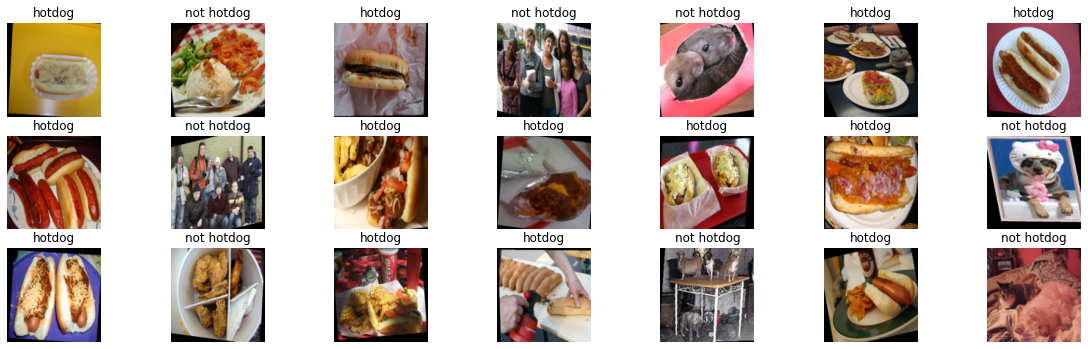

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Now create a model and train it!


In [ ]:
#check Size of the network
images.shape

torch.Size([64, 3, 128, 128])

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 16 ,kernel_size = 3, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),          
            nn.Dropout(0.5),
            nn.MaxPool2d(2), # size is 64x64x18  , 64=128/2

            nn.Conv2d(16, 32 ,kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(2), #the size is  32x32x18

            nn.Conv2d(32, 64 ,kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(2), #size 16x16x64
            
            # nn.Conv2d(20, 20 ,kernel_size = 3, padding = 1),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            )

        self.fully_connected = nn.Sequential(
            nn.Linear(16*16*64, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(500, 2),
            nn.Softmax(dim=1))
        #...
    def forward(self, x):

      x = self.convolutional(x)
      #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
      x = x.view(x.size(0), -1)
     # x = x.view(-1, 8* 16 * 16)
      x = self.fully_connected(x)
      #...
      return x

In [ ]:
model = Network()
model.to(device)
#Initialize the optimizer

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

#Get the first minibatch
data = next(iter(train_loader))[0].cuda()
#Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data); #if this runs the model dimensions fit

In [ ]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.nll_loss(torch.log(output), target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [ ]:
out = train(model, optimizer, 30)
# # ...
# # ...
# plt.legend(('Test error','Train eror'))
# plt.xlabel('Epoch number')
# plt.ylabel('Accuracy')


In [ ]:
plt.plot(out['test_acc'], label= 'Test Acc')
plt.plot(out['train_acc'], label= 'Train Acc')

plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

NameError: ignored

In [ ]:
# plt.plot(out['test_loss'], label= 'Test Loss')
# plt.plot(out['train_loss'], label= 'Train Loss')

# plt.legend()
# plt.xlabel('Epoch number')
# plt.ylabel('Loss')

In [ ]:
# !pip install -U skorch


In [ ]:
# type(data)

In [ ]:

# net = NeuralNetClassifier(
#     Network,
#     max_epochs=10,
#     optimizer=optim.Adam,
#     optimizer__lr = .005
#     # Shuffle training data on each epoch
#     #iterator_train__shuffle = True,
#     )

# lr= np.linspace(0.000000000000000000000000001, 0.1,50)
# params = {
#     'optimizer__lr': lr,
#     'max_epochs':[3,5,10],
#     'module__num_units': [14,20,28,36,42],
#     'module__drop' : [0,.1,.2,.3,.4]
# }

# #for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
# #data, target = data.to(device), target.to(device)

# gs = GridSearchCV(net,params,refit=True,scoring='r2',verbose=1, cv=5)
# gs.fit(data.cpu(),target.cpu())





1

In [ ]:
# class Network(nn.Module):
#     def __init__(self):
#         super(Network, self).__init__()

#         self.convolutional = nn.Sequential(
#             nn.Conv2d(3, 16 ,kernel_size = 3, padding = 1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),          
#             nn.Dropout(0.2),
#             nn.MaxPool2d(2), # size is 64x64x18  , 64=128/2

#             nn.Conv2d(16, 32 ,kernel_size = 3, padding = 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.MaxPool2d(2), #the size is  32x32x18

#             nn.Conv2d(32, 64 ,kernel_size = 3, padding = 1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.MaxPool2d(2), #size 16x16x64
            
#             # nn.Conv2d(20, 20 ,kernel_size = 3, padding = 1),
#             # nn.ReLU(),
#             # nn.Dropout(0.2),
#             )

#         self.fully_connected = nn.Sequential(
#             nn.Linear(16*16*64, 500),
#             nn.BatchNorm1d(500),
#             nn.ReLU(),
#             nn.Dropout(0.2),
            
#             nn.Linear(500, 2),
#             nn.Softmax(dim=1))
#         #...
#     def forward(self, x):

#       x = self.convolutional(x)
#       #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
#       x = x.view(x.size(0), -1)
#      # x = x.view(-1, 8* 16 * 16)
#       x = self.fully_connected(x)
#       #...
#       return x
# ##################################################################################""
# model = Network()
# model.to(device)
# #Initialize the optimizer

# #optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

# #Get the first minibatch
# data = next(iter(train_loader))[0].cuda()
# #Try running the model on a minibatch
# print('Shape of the output from the convolutional part', model.convolutional(data).shape)
# model(data); #if this runs the model dimensions fit

# ###########################################################################
# #We define the training as a function so we can easily re-use it.
# def train(model, optimizer, num_epochs=10):
#     def loss_fun(output, target):
#         return F.nll_loss(torch.log(output), target)
#     out_dict = {'train_acc': [],
#               'test_acc': [],
#               'train_loss': [],
#               'test_loss': []}
  
#     for epoch in tqdm(range(num_epochs), unit='epoch'):
#         model.train()
#         #For each epoch
#         train_correct = 0
#         train_loss = []
#         for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
#             data, target = data.to(device), target.to(device)
#             #Zero the gradients computed for each weight
#             optimizer.zero_grad()
#             #Forward pass your image through the network
#             output = model(data)
#             #Compute the loss
#             loss = loss_fun(output, target)
#             #Backward pass through the network
#             loss.backward()
#             #Update the weights
#             optimizer.step()

#             train_loss.append(loss.item())
#             #Compute how many were correctly classified
#             predicted = output.argmax(1)
#             train_correct += (target==predicted).sum().cpu().item()
#         #Comput the test accuracy
#         test_loss = []
#         test_correct = 0
#         model.eval()
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             with torch.no_grad():
#                 output = model(data)
#             test_loss.append(loss_fun(output, target).cpu().item())
#             predicted = output.argmax(1)
#             test_correct += (target==predicted).sum().cpu().item()
#         out_dict['train_acc'].append(train_correct/len(trainset))
#         out_dict['test_acc'].append(test_correct/len(testset))
#         out_dict['train_loss'].append(np.mean(train_loss))
#         out_dict['test_loss'].append(np.mean(test_loss))
#         print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
#               f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
#     return out_dict
# #####################################"""
# out = train(model, optimizer, 30)
# # # ...
# # # ...
# # plt.legend(('Test error','Train eror'))
# # plt.xlabel('Epoch number')
# # plt.ylabel('Accuracy')


2

In [ ]:
# class Network(nn.Module):
#     def __init__(self):
#         super(Network, self).__init__()

#         self.convolutional = nn.Sequential(
#             nn.Conv2d(3, 16 ,kernel_size = 3, padding = 1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),          
#             #nn.Dropout(0.2),
#             nn.MaxPool2d(2), # size is 64x64x18  , 64=128/2

#             nn.Conv2d(16, 32 ,kernel_size = 3, padding = 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             #nn.Dropout(0.2),
#             nn.MaxPool2d(2), #the size is  32x32x18

#             nn.Conv2d(32, 64 ,kernel_size = 3, padding = 1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             #nn.Dropout(0.2),
#             nn.MaxPool2d(2), #size 16x16x64
            
#             # nn.Conv2d(20, 20 ,kernel_size = 3, padding = 1),
#             # nn.ReLU(),
#             # nn.Dropout(0.2),
#             )

#         self.fully_connected = nn.Sequential(
#             nn.Linear(16*16*64, 500),
#             nn.BatchNorm1d(500),
#             nn.ReLU(),
#             #nn.Dropout(0.2),
#             nn.Linear(500, 2),
#             nn.Softmax(dim=1))
#         #...
#     def forward(self, x):

#       x = self.convolutional(x)
#       #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
#       x = x.view(x.size(0), -1)
#      # x = x.view(-1, 8* 16 * 16)
#       x = self.fully_connected(x)
#       #...
#       return x
# ##################################################################################""
# model = Network()
# model.to(device)
# #Initialize the optimizer

# #optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

# #Get the first minibatch
# data = next(iter(train_loader))[0].cuda()
# #Try running the model on a minibatch
# print('Shape of the output from the convolutional part', model.convolutional(data).shape)
# model(data); #if this runs the model dimensions fit

# ###########################################################################
# #We define the training as a function so we can easily re-use it.
# def train(model, optimizer, num_epochs=10):
#     def loss_fun(output, target):
#         return F.nll_loss(torch.log(output), target)
#     out_dict = {'train_acc': [],
#               'test_acc': [],
#               'train_loss': [],
#               'test_loss': []}
  
#     for epoch in tqdm(range(num_epochs), unit='epoch'):
#         model.train()
#         #For each epoch
#         train_correct = 0
#         train_loss = []
#         for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
#             data, target = data.to(device), target.to(device)
#             #Zero the gradients computed for each weight
#             optimizer.zero_grad()
#             #Forward pass your image through the network
#             output = model(data)
#             #Compute the loss
#             loss = loss_fun(output, target)
#             #Backward pass through the network
#             loss.backward()
#             #Update the weights
#             optimizer.step()

#             train_loss.append(loss.item())
#             #Compute how many were correctly classified
#             predicted = output.argmax(1)
#             train_correct += (target==predicted).sum().cpu().item()
#         #Comput the test accuracy
#         test_loss = []
#         test_correct = 0
#         model.eval()
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             with torch.no_grad():
#                 output = model(data)
#             test_loss.append(loss_fun(output, target).cpu().item())
#             predicted = output.argmax(1)
#             test_correct += (target==predicted).sum().cpu().item()
#         out_dict['train_acc'].append(train_correct/len(trainset))
#         out_dict['test_acc'].append(test_correct/len(testset))
#         out_dict['train_loss'].append(np.mean(train_loss))
#         out_dict['test_loss'].append(np.mean(test_loss))
#         print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
#               f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
#     return out_dict
# #####################################"""
# out = train(model, optimizer, 30)
# # # ...
# # # ...
# # plt.legend(('Test error','Train eror'))
# # plt.xlabel('Epoch number')
# # plt.ylabel('Accuracy')


3

In [ ]:
# class Network(nn.Module):
#     def __init__(self):
#         super(Network, self).__init__()

#         self.convolutional = nn.Sequential(
#             nn.Conv2d(3, 16 ,kernel_size = 3, padding = 1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),          
#             nn.Dropout(0.2),
#             nn.MaxPool2d(2), # size is 64x64x18  , 64=128/2

#             nn.Conv2d(16, 32 ,kernel_size = 3, padding = 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.MaxPool2d(2), #the size is  32x32x18

#             nn.Conv2d(32, 64 ,kernel_size = 3, padding = 1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.MaxPool2d(2), #size 16x16x64
            
#             # nn.Conv2d(20, 20 ,kernel_size = 3, padding = 1),
#             # nn.ReLU(),
#             # nn.Dropout(0.2),
#             )

#         self.fully_connected = nn.Sequential(
#             nn.Linear(16*16*64, 500),
#             nn.BatchNorm1d(500),
#             nn.ReLU(),
#             nn.Dropout(0.2),
            
#             nn.Linear(500, 2),
#             nn.Softmax(dim=1))
#         #...
#     def forward(self, x):

#       x = self.convolutional(x)
#       #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
#       x = x.view(x.size(0), -1)
#      # x = x.view(-1, 8* 16 * 16)
#       x = self.fully_connected(x)
#       #...
#       return x
# ##################################################################################""
# model = Network()
# model.to(device)
# #Initialize the optimizer

# #optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# #Get the first minibatch
# data = next(iter(train_loader))[0].cuda()
# #Try running the model on a minibatch
# print('Shape of the output from the convolutional part', model.convolutional(data).shape)
# model(data); #if this runs the model dimensions fit

# ###########################################################################
# #We define the training as a function so we can easily re-use it.
# def train(model, optimizer, num_epochs=10):
#     def loss_fun(output, target):
#         return F.nll_loss(torch.log(output), target)
#     out_dict = {'train_acc': [],
#               'test_acc': [],
#               'train_loss': [],
#               'test_loss': []}
  
#     for epoch in tqdm(range(num_epochs), unit='epoch'):
#         model.train()
#         #For each epoch
#         train_correct = 0
#         train_loss = []
#         for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
#             data, target = data.to(device), target.to(device)
#             #Zero the gradients computed for each weight
#             optimizer.zero_grad()
#             #Forward pass your image through the network
#             output = model(data)
#             #Compute the loss
#             loss = loss_fun(output, target)
#             #Backward pass through the network
#             loss.backward()
#             #Update the weights
#             optimizer.step()

#             train_loss.append(loss.item())
#             #Compute how many were correctly classified
#             predicted = output.argmax(1)
#             train_correct += (target==predicted).sum().cpu().item()
#         #Comput the test accuracy
#         test_loss = []
#         test_correct = 0
#         model.eval()
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             with torch.no_grad():
#                 output = model(data)
#             test_loss.append(loss_fun(output, target).cpu().item())
#             predicted = output.argmax(1)
#             test_correct += (target==predicted).sum().cpu().item()
#         out_dict['train_acc'].append(train_correct/len(trainset))
#         out_dict['test_acc'].append(test_correct/len(testset))
#         out_dict['train_loss'].append(np.mean(train_loss))
#         out_dict['test_loss'].append(np.mean(test_loss))
#         print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
#               f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
#     return out_dict
# #####################################"""
# out = train(model, optimizer, 30)
# # # ...
# # # ...
# # plt.legend(('Test error','Train eror'))
# # plt.xlabel('Epoch number')
# # plt.ylabel('Accuracy')


4

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64 ,kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),          
            #nn.Dropout(0.2),
            nn.MaxPool2d(2), # size is 64x64x18  , 64=128/2  ##64x64x64   #64_Con2d x 64x64 image

            nn.Conv2d(64, 32 ,kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.MaxPool2d(2), #the size is  32x32x18  ##32x32x32

            nn.Conv2d(32, 16 ,kernel_size = 3, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.MaxPool2d(2), #size 16x16x64 ## 16x16x16
            
            # nn.Conv2d(20, 20 ,kernel_size = 3, padding = 1),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            )

        self.fully_connected = nn.Sequential(
            nn.Linear(16*16*16, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(500, 2),
            nn.Softmax(dim=1))
        #...
    def forward(self, x):

      x = self.convolutional(x)
      #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
      x = x.view(x.size(0), -1)
     # x = x.view(-1, 8* 16 * 16)
      x = self.fully_connected(x)
      #...
      return x
##################################################################################""
model = Network()
model.to(device)
#Initialize the optimizer

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)

#Get the first minibatch
data = next(iter(train_loader))[0].cuda()
#Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data); #if this runs the model dimensions fit

###########################################################################
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.nll_loss(torch.log(output), target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict
#####################################"""



out = train(model, optimizer, 20)
# # ...
# # ...
# plt.legend(('Test error','Train eror'))
# plt.xlabel('Epoch number')
# plt.ylabel('Accuracy')


Shape of the output from the convolutional part torch.Size([64, 16, 16, 16])



Loss train: 0.586	 test: 0.600	 Accuracy train: 70.5%	 test: 65.1%



Loss train: 0.449	 test: 0.627	 Accuracy train: 79.3%	 test: 71.9%



Loss train: 0.392	 test: 0.501	 Accuracy train: 83.1%	 test: 76.4%



Loss train: 0.352	 test: 0.524	 Accuracy train: 84.5%	 test: 76.6%



Loss train: 0.341	 test: 0.497	 Accuracy train: 85.3%	 test: 76.3%



Loss train: 0.317	 test: 0.552	 Accuracy train: 86.3%	 test: 75.3%



Loss train: 0.294	 test: 0.511	 Accuracy train: 87.8%	 test: 77.2%



Loss train: 0.289	 test: 0.551	 Accuracy train: 87.5%	 test: 76.9%



Loss train: 0.281	 test: 0.537	 Accuracy train: 88.6%	 test: 76.3%



Loss train: 0.257	 test: 0.535	 Accuracy train: 89.6%	 test: 78.0%



Loss train: 0.265	 test: 0.526	 Accuracy train: 88.3%	 test: 77.1%



Loss train: 0.249	 test: 0.535	 Accuracy train: 90.0%	 test: 75.8%



Loss train: 0.223	 test: 0.537	 Accuracy train: 91.2%	 test: 75.9%



Loss train: 0.215	 test: 0.522	 Accuracy train: 91.1%	 test: 77.8%



Loss train: 0.226	 test: 0.730	 Accuracy train: 91.0%	 test: 70.7%



Loss train: 0.217	 test: 0.579	 Accuracy train: 91.3%	 test: 75.3%



Loss train: 0.203	 test: 0.501	 Accuracy train: 91.9%	 test: 78.9%



Loss train: 0.187	 test: 0.513	 Accuracy train: 93.4%	 test: 78.5%



Loss train: 0.208	 test: 0.510	 Accuracy train: 91.8%	 test: 78.9%



Loss train: 0.171	 test: 0.557	 Accuracy train: 93.7%	 test: 77.9%



## Visualzing misclassifications

In [ ]:
# iter_test_loader = iter(test_loader)
# data,target = next(iter_test_loader)
data, target = next(iter(test_loader))
model.eval()
data = data.to(device)
#with torch.no_grad():
output = model(data)
yhat = output.argmax(1).cpu()
test_acc = (target==yhat).sum().item()/len(data)
print('Test accuracy',test_acc)
#yhat

Test accuracy 0.890625


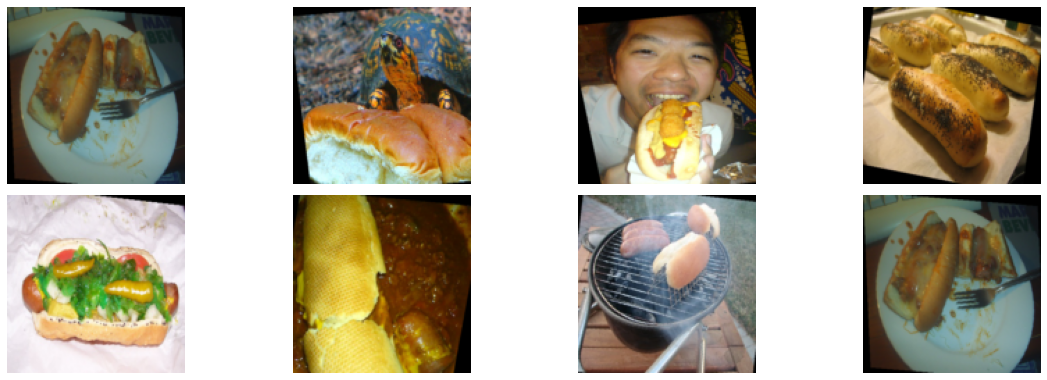

In [ ]:
test_fail = np.array((target!=yhat).numpy(),dtype=bool)
test_images_np=np.moveaxis(data.cpu().numpy(),1,-1)

failed_images = test_images_np[test_fail]
correct_images = test_images_np[~test_fail]

n_img_disp = 8
plt.figure(figsize=(16,8))
for i in range(n_img_disp):
    plt.subplot(3,4,i+1)
    plt.imshow(failed_images[i-4])
    plt.grid(False)
    plt.axis('off')
    plt.tight_layout()
    #plt.savefig('test_failed_images.png')
plt.show()

In [ ]:
#correct_images

## Correct images

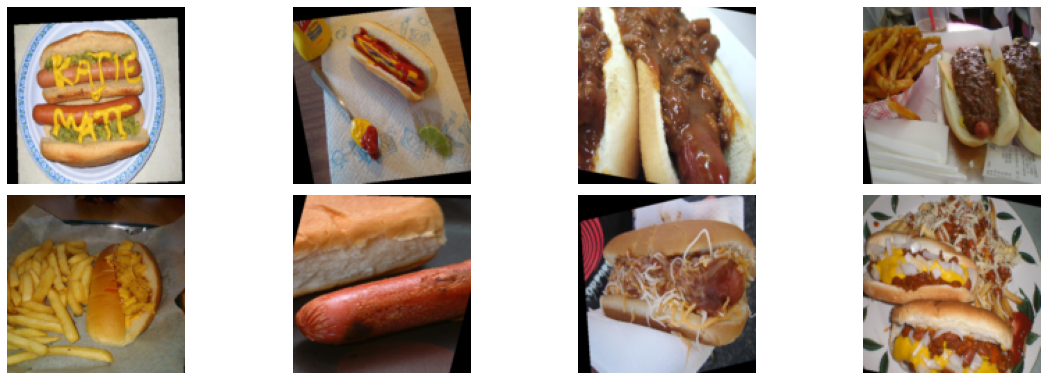

In [ ]:
# test_fail = np.array((target!=yhat).numpy(),dtype=bool)
# test_images_np=np.moveaxis(data.cpu().numpy(),1,-1)

# failed_images = test_images_np[test_fail]
# correct_images = test_images_np[~test_fail]

n_img_disp = 8
plt.figure(figsize=(16,8))
for i in range(n_img_disp):
    plt.subplot(3, 4 , i+1)
    #plt.subplot(2,5,i)
    plt.imshow(correct_images[i])
    plt.grid(False)
    plt.axis('off')
    plt.tight_layout()
    #plt.savefig('test_failed_images.png')
plt.show()

## Generation of noisy hotdog

In [ ]:
im_test, lab_test = next(iter(train_loader))
im_test[10].shape

In [ ]:
no = 15
plt.imshow(np.swapaxes(np.swapaxes(im_test[no].numpy(), 0, 2), 0, 1))
np.swapaxes(np.swapaxes(im_test[0].numpy(), 0, 2), 0, 1).shape

output = model(im_test[no].unsqueeze(0).to(device))

print(output)
print(output.argmax(1))

In [ ]:
img = torch.randn((3,128,128), requires_grad=True)

optimizer = torch.optim.Adam([img])
out = model(img.unsqueeze(0).to(device))

print('BEFORE:',out.detach().cpu().clone().numpy()[0][0])

i = 0
while i < 1000:

    out = model(img.unsqueeze(0).to(device))

    loss = loss_fun(out, torch.tensor([0]).cuda()) # compare out with 0 ? 
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    i += 1

out = model(img.unsqueeze(0).to(device))

print('AFTER:',out.detach().cpu().clone().numpy()[0][0])

plt.imshow(np.swapaxes(np.swapaxes(img.detach().numpy(), 0, 2), 0, 1))